### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Performance Metrics

In [2]:
def MaximumDrawdown(equity, text = ""):


    # Drawdown calculation
    equity['drawdowns'] = 1 - equity[text]/(equity[text].cummax())
    max_drawdown = equity['drawdowns'].max()
    start_index = equity['drawdowns'].idxmax()
    start_index = equity[text].loc[:start_index].idxmax()
    
    # Find the level of equity at the start of the drawdown
    start_equity_level = equity[text].loc[start_index]
    
    # Search for the index where equity returns to a level higher than or equal to the level at the start of the drawdown
    equity = equity.loc[start_index:]
    end_index = equity[text][equity[text] > start_equity_level].index.min()

    if str(start_index) == 'NaT':
        start_index = equity.index[0]
    if str(end_index) == 'NaT':
        end_index = equity.index[-1]


    return max_drawdown, start_index, end_index

In [39]:
def PerformanceMetrics(df, fix = 'base'):

    # Data
    equity = df.copy()
    equity = equity[[fix]]
    equity['Daily_return'] = equity[fix].pct_change()
    equity = equity.dropna()
    # ARC
    time = len(equity) / (60 * 24)
    #time = len(equity)
    ARC = (equity[fix].values[-1])**(252/time) - 1
    

    # aSD
    aSD = (equity[f'Daily_return'].std()) * np.sqrt(252)
    

    # Maximum Drawdown and Maximum Drawdown Duration
    MD, start_drawdown, end_drawdown = MaximumDrawdown(equity, fix)
    MLD = np.abs((end_drawdown - start_drawdown).days)/252.03

    # Information Ratio *
    IR1 = ARC/aSD

    # Information Ratio **
    IR2 = ARC**3/(aSD*ARC*MD*100)

    # Information Ratio ***
    IR3 = ARC**3/(aSD*MD*MLD*100)

    #print(f'ARC = {round(100*ARC, 3)}% aSD = {round(aSD, 5)} MD = {round(100*MD, 3)}% MLD = {round(MLD, 3)}yrs IR1 = {round(IR1, 3)} IR2 = {round(IR2, 3)} IR3 = {round(IR3, 3)}')

    metrics = {
        'ARC': 100*ARC,
        'aSD': aSD,
        'MD': 100*MD,
        'MLD': MLD,
        'IR1': IR1/100,
        'IR2': IR2,
        'IR3': IR3
    }
    
    return metrics

### Load equity curves

In [4]:
def get_tickers(path = 'Data\Real\Financial\microprocessor_stocks_2023-25.csv'):

    tickers = pd.read_csv(path)
    tickers = tickers['ticker'].unique()
    return tickers

In [5]:
def load_data(TICKERS):

    equities = []

    for ticker in TICKERS:
        
        X = pd.read_csv(f'Results\{ticker}_results.csv', index_col = False)
        X['date'] = pd.to_datetime(X['date'])
        X.index = X['date']
        X = X[['target', 'base', 'nlp']]
        X = X.dropna()
        if X.iloc[-1]['nlp'] > 1:
            print(f'Loading {ticker}...')
            equities.append(X)

    return equities

In [6]:
#pd.read_csv(f'Results\{TICKERS[10]}_results.csv', index_col = False)

In [7]:
TICKERS = get_tickers()
equities = load_data(TICKERS)

Loading NVDA...


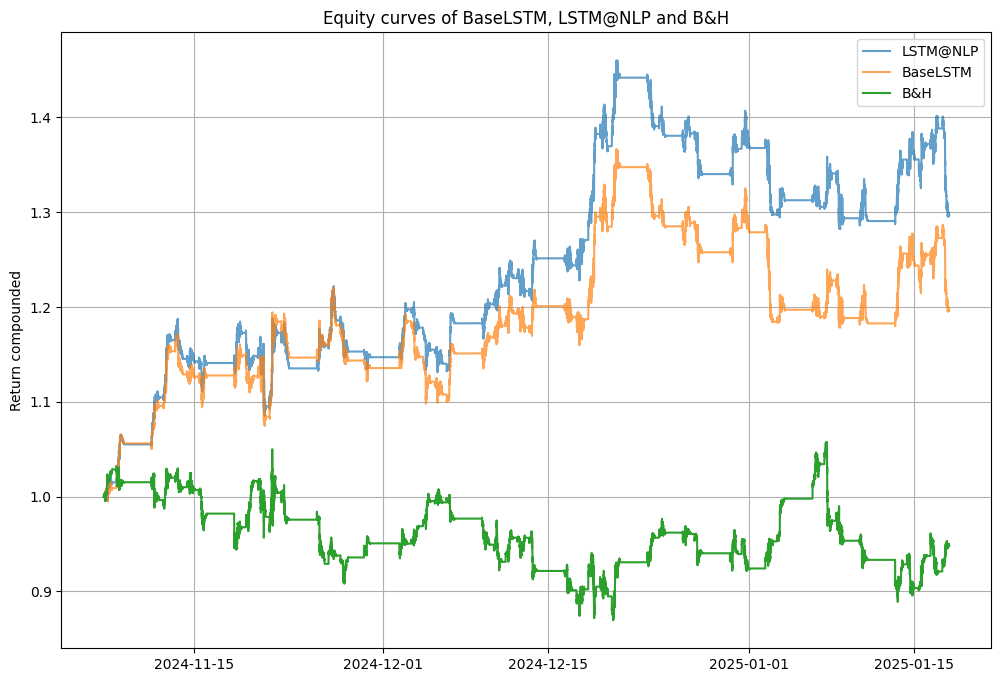

In [14]:
fig, ax1 = plt.subplots(figsize = (12,8))

for y in equities:

    ax1.plot(y['base'], label = 'LSTM@NLP', alpha = 0.7)
    ax1.plot(y['nlp'], label = 'BaseLSTM', alpha = 0.7)
    ax1.plot(y['target'], label = 'B&H')

plt.title('Equity curves of BaseLSTM, LSTM@NLP and B&H')
plt.ylabel('Return compounded')
plt.grid(True)
plt.legend()
plt.show()

In [40]:
results = pd.concat(
    [pd.DataFrame(PerformanceMetrics(equities[0], fix), index = list(range(1)))
     for fix in ['base', 'target', 'nlp']]
)
results.index = ['nlp', 'target', 'base']

In [41]:
print(results.round(3).to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
 & ARC & aSD & MD & MLD & IR1 & IR2 & IR3 \\
\midrule
nlp & 149.289000 & 0.010000 & 12.196000 & 0.111000 & 1.561000 & 19.103000 & 256.702000 \\
target & -17.137000 & 0.010000 & 17.183000 & 0.183000 & -0.175000 & 0.174000 & -0.164000 \\
base & 87.919000 & 0.010000 & 13.799000 & 0.111000 & 0.919000 & 5.855000 & 46.334000 \\
\bottomrule
\end{tabular}

